In [6]:
import os
import sys
## To enable relative import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [83]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
# import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
from torch.nn.functional import interpolate
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor,
                      LangevinCorrector,
                      EulerMaruyamaPredictor,
                      AncestralSamplingPredictor,
                      NoneCorrector,
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets
print('\n\n---------import complete------------')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---------import complete------------


### Load score-based models

In [8]:

checkpoint_path = '/home/yl241/models/NCSNPP/official/score_sde_checkpoints_pytorch'
sde = 'VESDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde.lower() == 'vesde':
  from configs.ml_collections_configs.ve import cifar10_ncsnpp_continuous as configs
  ckpt_filename = checkpoint_path + "/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
  config = configs.get_config()
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
  sampling_eps = 1e-5
elif sde.lower() == 'vpsde':
  from configs.ml_collections_configs.vp import cifar10_ddpmpp_continuous as configs
  ckpt_filename = checkpoint_path + "/vp/cifar10_ddpmpp_continuous/checkpoint_8.pth"
  config = configs.get_config()
  sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3
elif sde.lower() == 'subvpsde':
  from configs.ml_collections_configs.subvp import cifar10_ddpmpp_continuous as configs
  ckpt_filename = checkpoint_path + "/subvp/cifar10_ddpmpp_continuous/checkpoint_26.pth"
  config = configs.get_config()
  sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3
    
config.device = torch.device('cuda:0')  # OVERRRIDING

batch_size =   64 #@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

In [76]:
# title Visualization code

def image_grid(x, size=None):
  if size is None:
      size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x, size=None):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x, size)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

## PC Inpainting

2023-07-16 23:54:32.137812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 65199 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2023-07-16 23:54:32.651987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-16 23:54:32.652482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


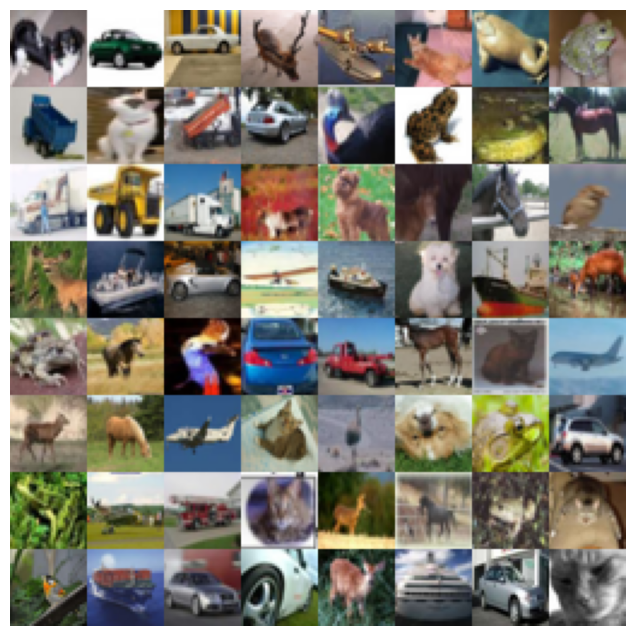

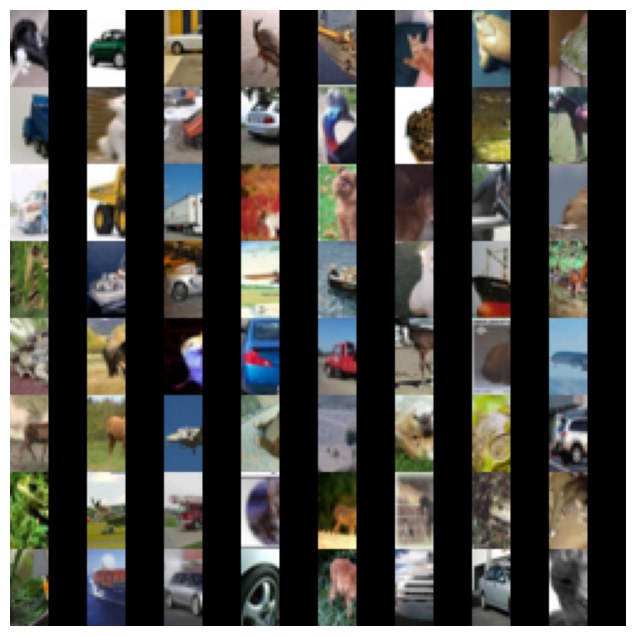

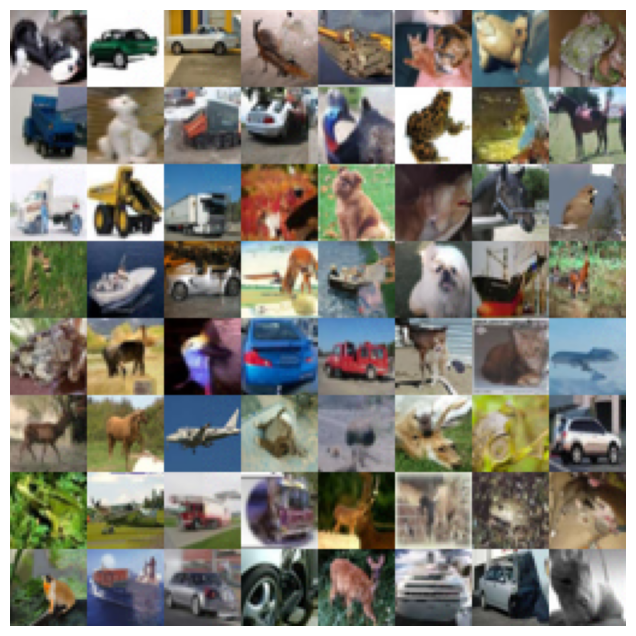

In [11]:
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)
batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)

mask = torch.ones_like(img)
mask[:, :, :, 16:] = 0.
show_samples(img * mask)


x = pc_inpainter(score_model, scaler(img), mask)
show_samples(x)

## Super-resolution

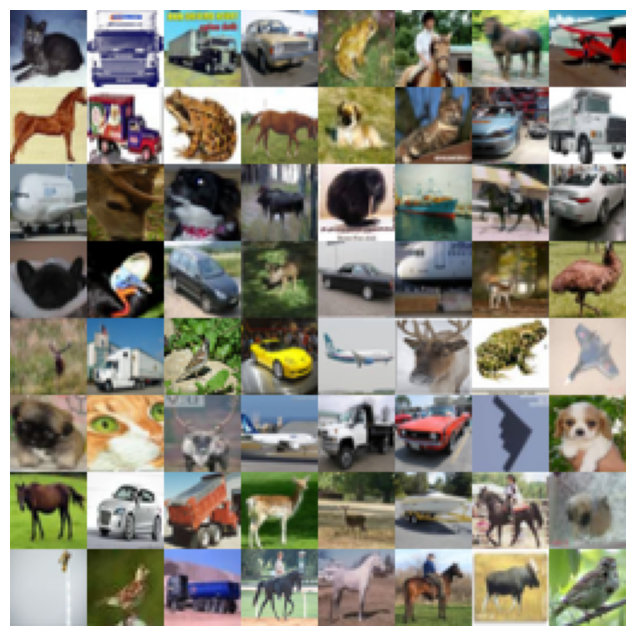

Original dimension =  torch.Size([64, 3, 32, 32])


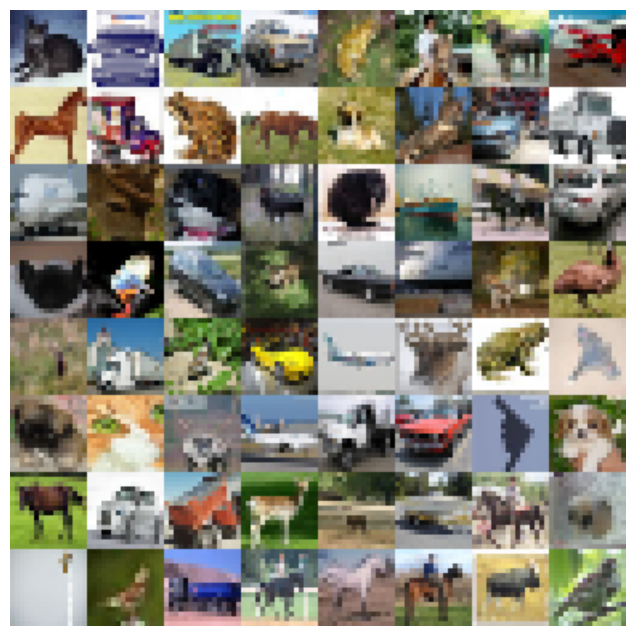

blur_img dimension =  torch.Size([64, 3, 32, 32])


In [90]:
scale_factor = 0.5
batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)
print('Original dimension = ', img.shape)
ds_img = interpolate(img, scale_factor=scale_factor)
blur_img = interpolate(ds_img, scale_factor=1 / scale_factor)
show_samples(blur_img) # size=int(config.data.image_size * scale_factor))
print('blur_img dimension = ', blur_img.shape)

2023-07-17 00:44:28.826278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-17 00:44:28.826775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


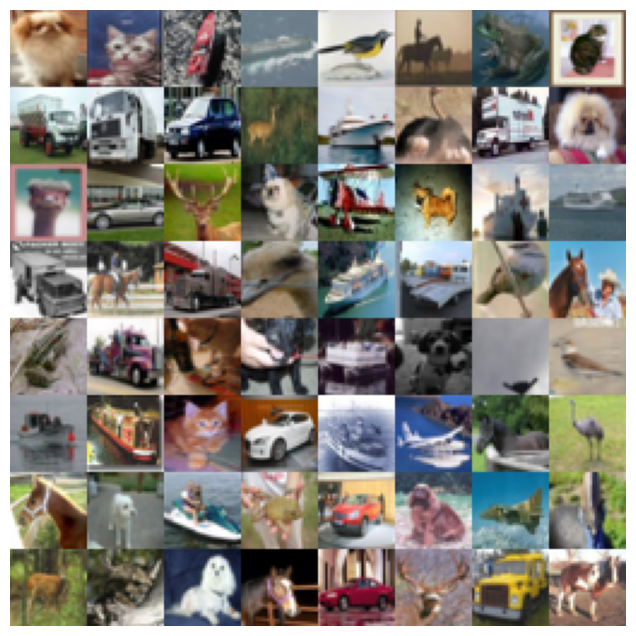

Original dimension =  torch.Size([64, 3, 32, 32])


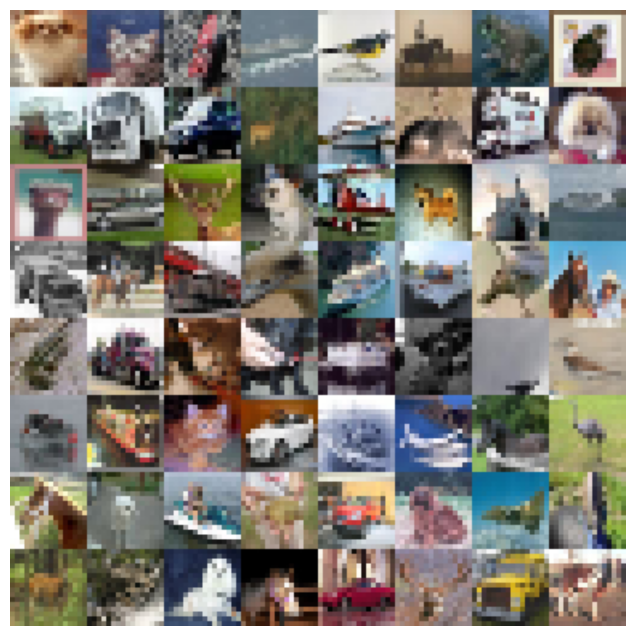

blur_img dimension =  torch.Size([64, 3, 32, 32])


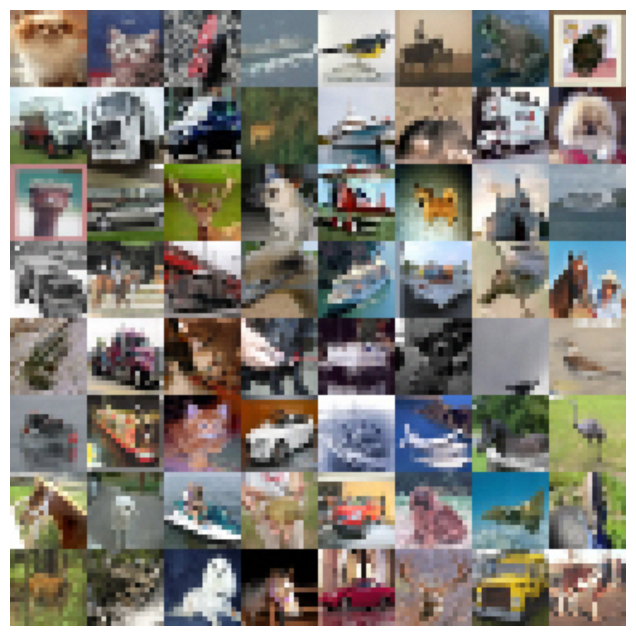

Up sampled results with mask =  0.2


In [97]:
scale_factor = 0.5

train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)

batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)
print('Original dimension = ', img.shape)
ds_img = interpolate(img, scale_factor=scale_factor)
blur_img = interpolate(ds_img, scale_factor=1 / scale_factor)
show_samples(blur_img) # size=int(config.data.image_size * scale_factor))
print('blur_img dimension = ', blur_img.shape)

mask = torch.ones_like(img) * 0.2
x = pc_inpainter(score_model, scaler(blur_img), mask)
show_samples(x)
print('Up sampled results with mask = ', 0.2)

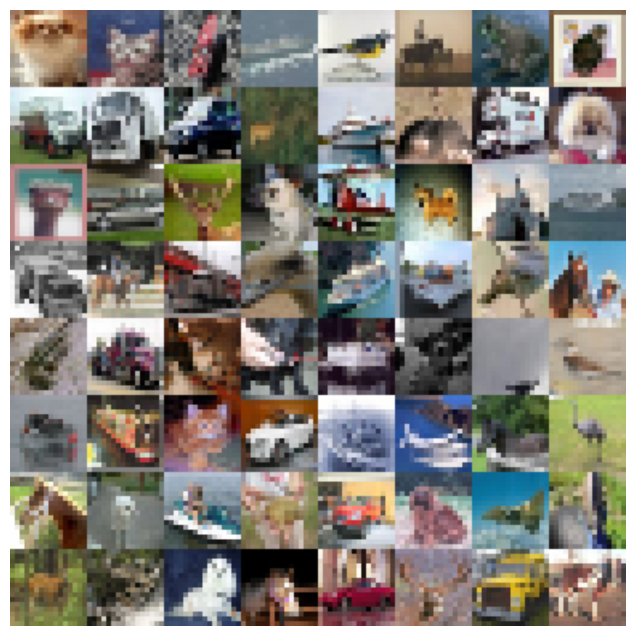

Up sampled results with mask =  0.8


In [98]:
mask = torch.ones_like(img) * 0.8
x = pc_inpainter(score_model, scaler(blur_img), mask)
show_samples(x)
print('Up sampled results with mask = ', 0.8)

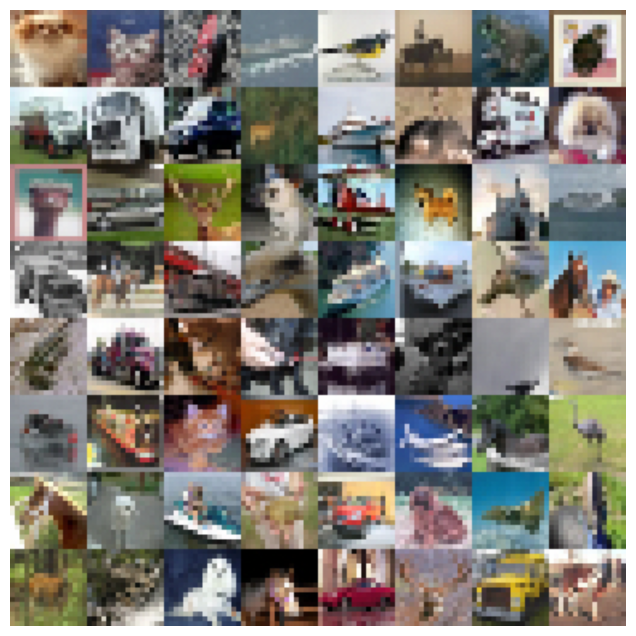

Up sampled results with mask =  0.5


In [99]:
mask = torch.ones_like(img) * 0.5
x = pc_inpainter(score_model, scaler(blur_img), mask)
show_samples(x)
print('Up sampled results with mask = ', 0.5)

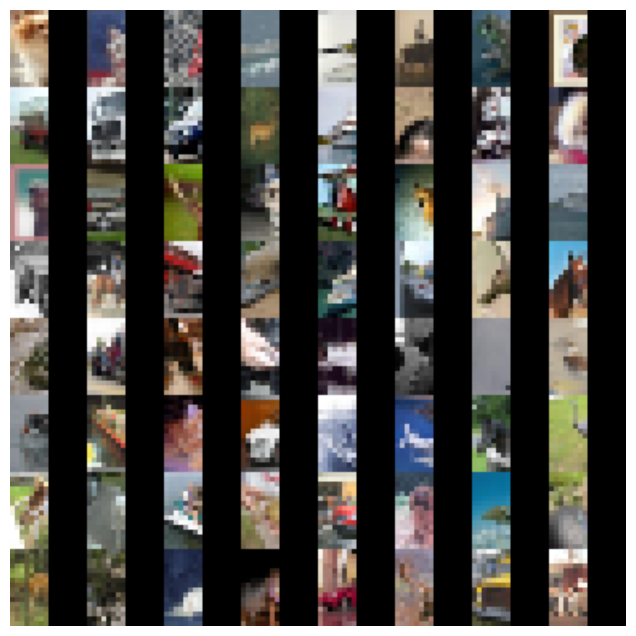

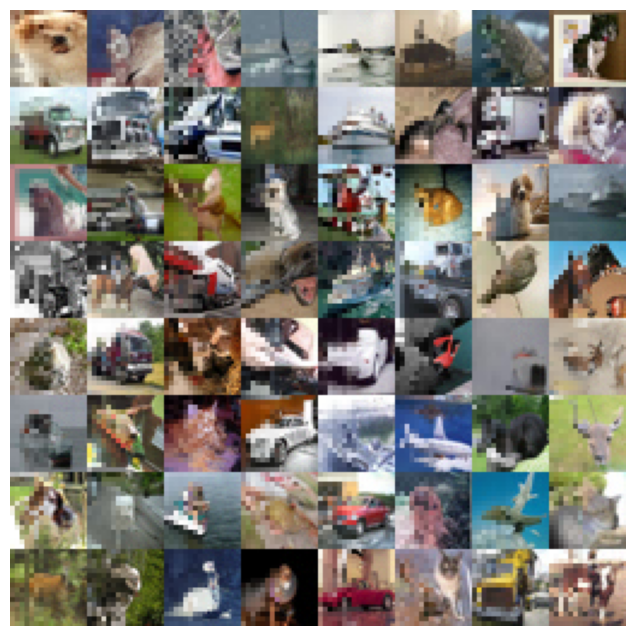

In [111]:
# trying blocking half of the image
mask = torch.ones_like(img)
mask[:, :, :, 16:] = 0.
show_samples(blur_img * mask)
x = pc_inpainter(score_model, scaler(blur_img), mask)
show_samples(x)